# Pricing Test Data Challenge

## Challenge Description

The goal of this challenge is to evaluate whether a pricing test running on a site has been successful.

Company XYZ sells a software for 39 dollars. Revenue has been flat for some time, and the VP of Product has decided to run a test increasing the price. She hopes this will increase revenue. In the experiment, 66 percent of the users have seen the old price (39 dollars), while a random sample of 33 percent users a higher price (59 dollars).

The test has been running for some time, and now the VP of Product is interested in understanding how it went and whether it would make sense to increase the price for all the users.

Specifically, she asks you the following questions:

* Should the company sell its software for 39 dollars or 59 dollars?

The VP of Product is interested in having a holistic view into user behavior, especially focusing on actionable insights that might increase conversion rate. 

* What are your main findings looking at the data?

**[Bonus]** The VP of Product feels that the test has been running for too long and he should have been able to get statistically significant results in a shorter time. 

* Do you agree with her intuition? 
* After how many days you would have stopped the test?
* Explain why.

First we need to load in the dataset and some useful packages

**Table 1**: "test_results" - data about the test

Columns:
* user_id : the Id of the user. Can be joined to user_id in user_table
* timestamp : the date and time when the user hit for the first time company XYZ webpage. It is in user local time
* source : marketing channel that led to the user coming to the site. It can be:
    * ads-["google", "facebook", "bing", "yahoo", "other"]. That is, user coming from google ads, yahoo ads, etc.
    * seo - ["google", "facebook", "bing", "yahoo", "other"]. That is, user coming from google search, yahoo, facebook, etc.
    * friend_referral : user coming from a referral link of another user
    * direct_traffic: user coming by directly typing the address of the site on the browser
* device : user device. Can be mobile or web
* operative_system : user operative system. Can be: "windows", "linux", "mac" for web, and "android", "iOS" for mobile.  Other  if it is none of the above
* test: whether the user was in the test (i.e. 1 -> higher price) or in control (0 -> old lower price)
* price : the price the user sees. It should match test
* converted : whether the user converted (i.e. 1 -> bought the software) or not (0 -> left the site without buying it).

**Table 2**: "user_table" - Information about the user

Columns:
* user_id : the Id of the user. Can be joined to user_id in test_results table
* city : the city where the user is * located. Comes from the user ip address
* country : in which country the city is located
* lat : city latitude - should match user city
* long : city longitude - should match user city

In [82]:
# Import some packages we'll use
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pandas.plotting import scatter_matrix
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import seaborn as sns
from itertools import product
import lifelines as ll
from sklearn.preprocessing import scale
import scipy.stats  as stats
from mpl_toolkits.basemap import Basemap
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats.stats import pearsonr
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

/Users/scottmorello/anaconda/envs/my_projects_env/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
# Import the data into a Pandas dataframe

test_results = pd.read_csv("/Users/scottmorello/Dropbox/Archives/Jobs/Insight_Data_Science/Data_Challenges/Insight_Data_Challenges/Data_Challenge_2/Pricing_Test/test_results.csv")

user_table = pd.read_csv("/Users/scottmorello/Dropbox/Archives/Jobs/Insight_Data_Science/Data_Challenges/Insight_Data_Challenges/Data_Challenge_2/Pricing_Test/user_table.csv")

In [5]:
# Checkout the data
test_results.head(5)

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [6]:
user_table.head(5)

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [7]:
print test_results.dtypes
print ""
print user_table.dtypes

user_id              int64
timestamp           object
source              object
device              object
operative_system    object
test                 int64
price                int64
converted            int64
dtype: object

user_id      int64
city        object
country     object
lat        float64
long       float64
dtype: object


In [8]:
# Convert the timestamp to date times

# There is a problem with one of the datetimes though - seems to be a minute value >59, and we need to find it.
# We start by separating out all the date and time elements, and correcting for anything 60+ (convrerting it to 59)
def checkMinute(minute):
    minute = int(minute)
    if minute >59:
        return '59'
    else:
        return str(minute)
    
test_results['year'] = [int(x[:4]) for x in test_results['timestamp']]
test_results['month'] = [int(x[5:7]) for x in test_results['timestamp']]
test_results['day'] = [int(x[8:10]) for x in test_results['timestamp']]
test_results['hour'] = [int(x[11:13]) for x in test_results['timestamp']]
test_results['minute'] = [int(checkMinute(x[14:16])) for x in test_results['timestamp']]
test_results['second'] = [int(checkMinute(x[17:])) for x in test_results['timestamp']]

test_results['timestamp'] = pd.to_datetime(test_results[['year', 'month', 'day', 'hour', 'minute', 'second']])

In [9]:
# Checkout the data
test_results.head(5)

,user_id,timestamp,source,device,operative_system,test,price,converted,year,month,day,hour,minute,second
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,2015,5,8,3,38,34
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,2015,5,10,21,8,46
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,2015,4,4,15,1,23
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,2015,5,7,7,26,1
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,2015,5,24,11,4,40


In [10]:
print test_results.dtypes
print ""
print user_table.dtypes

user_id                      int64
timestamp           datetime64[ns]
source                      object
device                      object
operative_system            object
test                         int64
price                        int64
converted                    int64
year                         int64
month                        int64
day                          int64
hour                         int64
minute                       int64
second                       int64
dtype: object

user_id      int64
city        object
country     object
lat        float64
long       float64
dtype: object


In [11]:
#make sure each user is only recorded once
test_results.groupby('user_id').count().max()

timestamp           1
source              1
device              1
operative_system    1
test                1
price               1
converted           1
year                1
month               1
day                 1
hour                1
minute              1
second              1
dtype: int64

In [12]:
# Check to NAs, but there don't seem to be any
print test_results.isnull().sum()
print ""
print user_table.isnull().sum()

user_id             0
timestamp           0
source              0
device              0
operative_system    0
test                0
price               0
converted           0
year                0
month               0
day                 0
hour                0
minute              0
second              0
dtype: int64

user_id    0
city       0
country    0
lat        0
long       0
dtype: int64


Now that we've cleaned up the dates and times, lets take a look at the data

In [13]:
test_results.describe()

,user_id,test,price,converted,year,month,day,hour,minute,second
count,316800.000000,316800.000000,316800.000000,316800.000000,316800.0,316800.000000,316800.000000,316800.000000,316800.000000,316800.000000
mean,499281.341840,0.360079,46.205051,0.018333,2015.0,4.041717,15.880944,11.886711,30.450792,30.493867
std,288591.154044,0.480024,9.601487,0.134154,0.0,0.822258,8.773255,5.057224,17.285751,17.302947
min,3.000000,0.000000,39.000000,0.000000,2015.0,3.000000,1.000000,0.000000,1.000000,1.000000
25%,249525.750000,0.000000,39.000000,0.000000,2015.0,3.000000,8.000000,9.000000,15.000000,15.000000
50%,499021.500000,0.000000,39.000000,0.000000,2015.0,4.000000,16.000000,12.000000,30.000000,30.000000
75%,749025.500000,1.000000,59.000000,0.000000,2015.0,5.000000,23.000000,15.000000,45.000000,46.000000
max,1000000.000000,1.000000,59.000000,1.000000,2015.0,5.000000,31.000000,23.000000,59.000000,59.000000


We can already see that year won't matter, since all the data comes from a single year

test and converted are Binary, and the test took place between March and May.

Let's go on to explore the data in plots

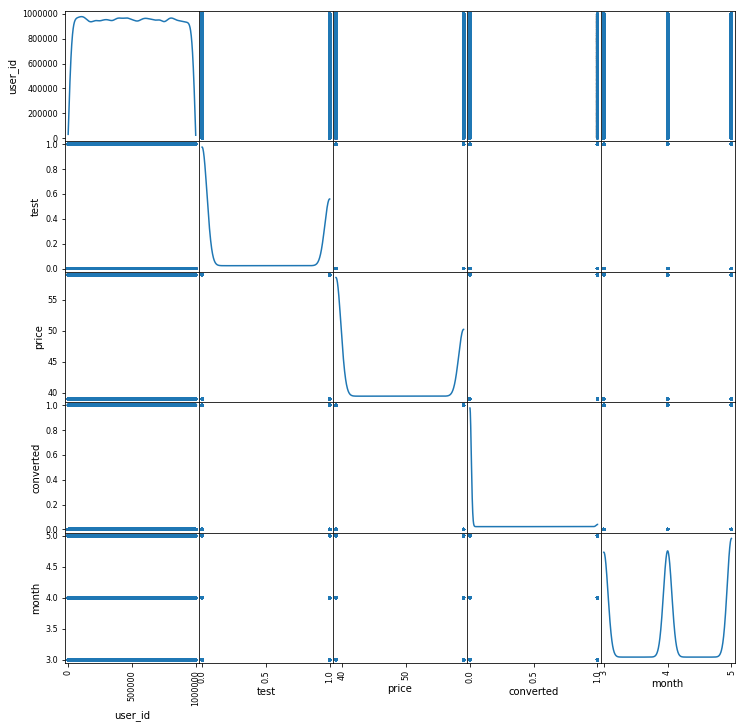

In [14]:
# This is a better way to get a quick look at the data. We force the diagonal
# (ie., the distributions of each varable) to be a denisty fuction, so we can asses the distributions.
pd.plotting.scatter_matrix(test_results[['user_id','test','price','converted','month']], figsize=(12, 12), diagonal='kde')
plt.show()

We can already see that months are pretty well balanced, and the test set is unblanaced as described (~66% low cost, 33% high cost). We can also see that the test binary variable doesn't necessarily line up with the price... which is wrong. we should double check this in a bit. Lasstly, we see that very few events converted. This could be a problem during any test. We'll need to keep this in mind for any evaluation.

To Do:

* Check that all test cases have their correct price associated with them. If not, choose "test" or "price" as the true value, and fix the other.

* Check the balance in the coverted dataset, and adjust if needed.

In [15]:
test_results.groupby(['test','price']).converted.count()

test  price
0     39       202517
      59          210
1     39          155
      59       113918
Name: converted, dtype: int64

As suspected, something wrong with the pice vs test comparison. Based on the imbalance, it seems like Test is accurate, and Price is not. let's remove the individuals that have the wrong price associated with them, since we're unclear how that happened (i.e., which way they were actually misclassified).

In [16]:
test_results = test_results.query('(test == 0 and price == 39) or (test == 1 and price == 59)')
test_results.groupby(['test','price']).converted.count()

test  price
0     39       202517
1     59       113918
Name: converted, dtype: int64

Now to look at conversion rates

In [17]:
test_results.groupby(['price','month','converted']).user_id.count()

price  month  converted
39     3      0            62994
              1             1261
       4      0            64237
              1             1341
       5      0            71256
              1             1428
59     3      0            35800
              1              589
       4      0            35825
              1              546
       5      0            40521
              1              637
Name: user_id, dtype: int64

Conversions already look balanced by month within each test, and it seems like sample sizes are approximately 2x pretty consistently between groups. It already looks as if there are more conversions per month for the lower proce than the higher proce, but that's not standardized by # of individuals yet, at which point they might be pretty equivlent

In [18]:
test_results_convertSummary = test_results.groupby(['price','month','converted']).user_id.count().unstack()
test_results_convertSummary.columns = ['no','yes']
test_results_convertSummary['proportion_converted'] = test_results_convertSummary.yes/test_results_convertSummary.no
test_results_convertSummary

no   yes  proportion_converted
price month                                   
39    3      62994  1261              0.020018
      4      64237  1341              0.020876
      5      71256  1428              0.020040
59    3      35800   589              0.016453
      4      35825   546              0.015241
      5      40521   637              0.015720

We'll want to separate source into different categories, so that we can parse out different paths of traffic (i.e., facebook vs google, seo vs adds)

In [19]:
print test_results.groupby(['source','device','operative_system']).user_id.count()
print ""
print 'unique sources: ' + str(test_results.source.unique())

source        device  operative_system
ads-bing      mobile  android              5374
                      iOS                  6907
                      other                1230
              web     linux                 247
                      mac                  1725
                      other                  27
                      windows              7321
ads-google    mobile  android             13887
                      iOS                 18144
                      other                2843
              web     linux                 878
                      mac                  4714
                      other                  13
                      windows             18863
ads-yahoo     mobile  android              1769
                      iOS                  2302
                      other                 367
              web     linux                  87
                      mac                   585
                      other                  10
 

It looks like we only need to separate out the source column, and we can do that based on:

* marketing type:
    * ads
    * seo

* marketing locaiton
    * bing
    * google
    * yahoo
    * facebook
    * other

two sources that might encompass both, and don't have a group for either, are

    * direct_traffic
    * friend_referral
    
It also looks like "other" is a pretty sparce category for Operating system, and also pretty uninformative. Let's get rid of it in the cleaning process.

In [20]:
test_results = test_results.query('operative_system != "other"')

In [21]:
def source_marketType(sourceVal):
    if "ads" in sourceVal:
        return "ads"
    elif "seo" in sourceVal:
        return "seo"
    elif "direct_traffic" in sourceVal:
        return "direct_traffic"
    elif "friend_referral" in sourceVal:
        return "friend_referral"
    else:
        return 'NA'
    
def source_marketLocation(sourceVal):
    if "bing" in sourceVal:
        return "bing"
    elif "google" in sourceVal:
        return "google"
    elif "yahoo" in sourceVal:
        return "yahoo"
    elif "facebook" in sourceVal:
        return "facebook"
    elif "direct_traffic" in sourceVal:
        return "direct_traffic"
    elif "friend_referral" in sourceVal:
        return "friend_referral"
    elif "other" in sourceVal:
        return "other"
    else:
        return 'NA'
    
test_results['marketType'] = [source_marketType(x) for x in test_results['source']]
test_results['marketLocation'] = [source_marketLocation(x) for x in test_results['source']]

In [22]:
test_results.head(5)

,user_id,timestamp,source,device,operative_system,test,price,converted,year,month,day,hour,minute,second,marketType,marketLocation
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,2015,5,8,3,38,34,ads,facebook
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,2015,5,10,21,8,46,seo,google
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,2015,4,4,15,1,23,ads,bing
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,2015,5,7,7,26,1,direct_traffic,direct_traffic
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,2015,5,24,11,4,40,ads,facebook


In [23]:
test_results_marketSummary = test_results.groupby(['price','marketType','marketLocation','converted']).user_id.count().unstack()
test_results_marketSummary.columns = ['no','yes']
test_results_marketSummary['proportion_converted'] = test_results_marketSummary.yes/test_results_marketSummary.no
test_results_marketSummary

no  yes  proportion_converted
price marketType      marketLocation                                   
39    ads             bing             13622  188              0.013801
                      facebook         31434  779              0.024782
                      google           35139  814              0.023165
                      other            17934  285              0.015892
                      yahoo             4488   79              0.017602
      direct_traffic  direct_traffic   36175  507              0.014015
      friend_referral friend_referral  12048  530              0.043991
      seo             bing              1234   39              0.031605
                      facebook         12502  228              0.018237
                      google           13964  249              0.017832
                      other             5521  101              0.018294
                      yahoo             4092   84              0.020528
59    ads             bing              7686   78              0.010148
                      facebook         18007  318              0.017660
                      google           20129  404              0.020071
                      other             9905  128              0.012923
                      yahoo             2597   30              0.011552
      direct_traffic  direct_traffic   20275  209              0.010308
      friend_referral friend_referral   6968  242              0.034730
      seo             bing               765   11              0.014379
                      facebook          7210  100              0.013870
                      google            7504  126              0.016791
                      other             3148   39              0.012389
                      yahoo             2319   24              0.010349

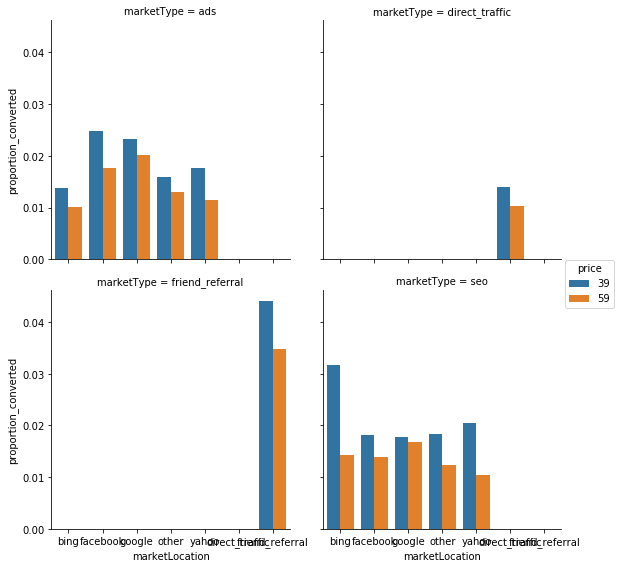

In [24]:
sns.factorplot(x="marketLocation", y="proportion_converted", col="marketType",hue="price",col_wrap=2,size=4,
                    data=test_results_marketSummary.reset_index(),
                    kind="bar")
plt.show()

Just looking at the proportion of conversions, it seems as if there is consistently higher conversion for the lower price, but that conversion varies by market_locaiton, and moreso than market-type. This seems like an aditive realtion, and not an interactive relationship.

let's take a look at the regional data from the other table.

In [25]:
user_table.country.unique()

array(['USA'], dtype=object)

Looks like we're only dealing within the US, so we can ignore country

In [26]:
len(user_table.city.unique())

923

We have a LOT of cities though, so let's try to reduce the number using the long and lat and a kmean clustering approach

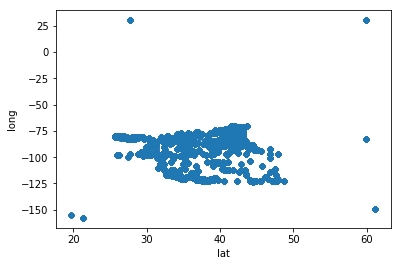

In [27]:
user_table.plot('lat','long',kind='scatter')
plt.show()


We can already see some majopr outliers spatially. Let's see where those are and try to remove them.

In [28]:
long_mean = np.mean(user_table.long)
long_std = np.std(user_table.long)
long_min = long_mean-(1.96*long_std)
long_max =  long_mean+(1.96*long_std)

lat_mean = np.mean(user_table.lat)
lat_std = np.std(user_table.lat)
lat_min = lat_mean-(1.96*lat_std)
lat_max =  lat_mean+(1.96*lat_std)

user_table = user_table.query('long <= ' + str(long_max) +' and long >= ' + str(long_min) +' and lat <= ' + str(lat_max) +' and lat >= ' + str(lat_min))


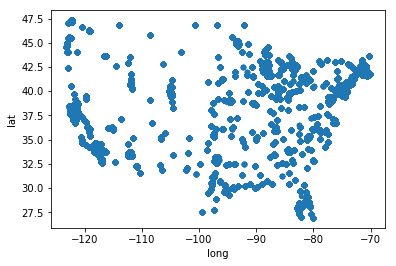

In [34]:
user_table.plot('long','lat',kind='scatter')
plt.show()

That looks better now. Let's cluster them into groups.

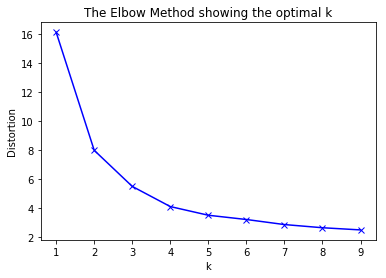

In [30]:
# k means determine k
X = user_table[['lat','long']]
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
 
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


Lets say we're not geting much more useful info after 4 clusters, and go with that. So in this case, we're assuming results might change regionally

In [35]:
city_clusters = KMeans(n_clusters=4).fit(user_table[['lat','long']])
city_id = city_clusters.predict(user_table[['lat','long']]).tolist()
user_table['city_id'] = np.add(city_id,1)
user_table.head(5)

,user_id,city,country,lat,long,city_id
0,510335,Peabody,USA,42.53,-70.97,3
1,89568,Reno,USA,39.54,-119.82,2
2,434134,Rialto,USA,34.11,-117.39,2
3,289769,Carson City,USA,39.15,-119.74,2
4,939586,Chicago,USA,41.84,-87.68,1


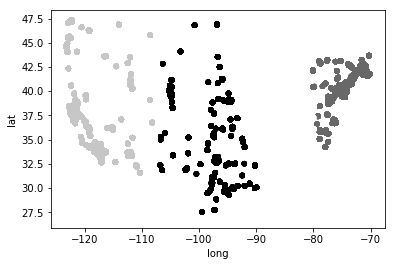

In [36]:
user_table.plot('long','lat',color=city_id,kind='scatter')
plt.show()

It looks as if things clustered by longitude. lt's let that hold for now.

Let's match city_id to user data in the other table

In [37]:
test_results = pd.merge(test_results, user_table, left_on = ['user_id'], right_on = ['user_id'])
test_results.head(5)

,user_id,timestamp,source,device,operative_system,test,price,converted,year,month,...,hour,minute,second,marketType,marketLocation,city,country,lat,long,city_id
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,2015,5,...,3,38,34,ads,facebook,Buffalo,USA,42.89,-78.86,3
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,2015,5,...,21,8,46,seo,google,Lakeville,USA,44.68,-93.24,1
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,2015,4,...,15,1,23,ads,bing,Parma,USA,41.38,-81.73,1
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,2015,5,...,7,26,1,direct_traffic,direct_traffic,Fayetteville,USA,35.07,-78.90,3
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,2015,5,...,11,4,40,ads,facebook,Fishers,USA,39.95,-86.02,1


OK, now let's make a dataframe to run through a logistic regression, to understand where the siginificant variaiton is

In [42]:
test_results_Sub = test_results[['converted','test','month','hour','device','marketType','marketLocation','city_id']]
test_results_Sub.dtypes

converted          int64
test               int64
month              int64
hour               int64
device            object
marketType        object
marketLocation    object
city_id            int64
dtype: object

In [43]:
# turn items into categories, and one-hot-encode them, and turn hours into quarter hours on the clock
test_results_Sub.converted = test_results_Sub.converted.astype(bool)
test_results_Sub.test = test_results_Sub.test.astype(bool)
test_results_Sub.month = test_results_Sub.month.astype("category")
test_results_Sub.device = test_results_Sub.device.astype("category")
test_results_Sub.marketType = test_results_Sub.marketType.astype("category")
test_results_Sub.marketLocation = test_results_Sub.marketLocation.astype("category")
test_results_Sub.city_id = test_results_Sub.city_id.astype("category")

def hourChange(hour):
    if hour>=0 and hour <6:
        return 1
    elif hour>=6 and hour <12:
        return 2
    elif hour>=12 and hour <18:
        return 3
    elif hour>=18 and hour <24:
        return 4
    
test_results_Sub.hour = [hourChange(x) for x in test_results_Sub.hour]
test_results_Sub.hour = test_results_Sub.hour.astype("category")

test_results_Sub.dtypes

converted             bool
test                  bool
month             category
hour              category
device            category
marketType        category
marketLocation    category
city_id           category
dtype: object

In [116]:
test_results_Sub_Summary = test_results_Sub.groupby(['test','marketType','marketLocation','city_id','hour','converted']).month.count().unstack()
test_results_Sub_Summary.columns = ['no','yes']
test_results_Sub_Summary['proportion_converted'] = test_results_Sub_Summary.yes/test_results_Sub_Summary.no
test_results_Sub_Summary = test_results_Sub_Summary.fillna(0)
test_results_Sub_Summary.head(5)


no   yes  \
test  marketType marketLocation city_id hour                 
False ads        bing           1       1      331.0   6.0   
                                        2     1123.0   9.0   
                                        3     1211.0  12.0   
                                        4      428.0   5.0   
                                2       1      330.0   3.0   

                                              proportion_converted  
test  marketType marketLocation city_id hour                        
False ads        bing           1       1                 0.018127  
                                        2                 0.008014  
                                        3                 0.009909  
                                        4                 0.011682  
                                2       1                 0.009091

In [105]:
test_results_Sub2 = test_results_Sub[['converted','test']]
y1, X1 = dmatrices('converted ~ test',
                  test_results_Sub2, return_type="dataframe")
y1 = np.ravel(y1['converted[True]'])

glm_binom = sm.GLM(y1, X1, family=sm.families.Binomial(),class_weight='balanced')
res = glm_binom.fit()
print res.summary()



                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:               247107
Model:                            GLM   Df Residuals:                   247105
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -22663.
Date:                Sun, 15 Oct 2017   Deviance:                       45327.
Time:                        21:49:47   Pearson chi2:                 2.47e+05
No. Iterations:                     7                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -3.8900      0.018   -216.678      0.000      -3.925      -3.855
test[T.True]    -0.2567      0.032     -7.904 

In [107]:
print np.exp( -0.2567) 

0.773600259035


In [109]:
59*np.exp( -0.2567)

45.6424152830431

So there's a negative effect of test on the conversion rate. Only 77.36 times out of 100 will the site convert a user if the price is increased... but, at the new price of 59 dollars, that means the average yield per user is still 46 dollars rather than 39 dollars, so the CEO should probably increase the price.

let's see if we can parse out any other effects in the dataset

based on a power calculation using this odds ratio, and alpha of 0.05, and the probabilities seen in the data, we need approximately 42000 samples to achieve 80% power. We obsaerved a total of 247107 individuals.

In [171]:
247107-42000

205107

This suggesgts we could have stopped the experiment much earlier (205,107 users earlier) and still detected this difference.

In [115]:
test_results_Sub2 = test_results_Sub.query('test == 0')
y, X = dmatrices('converted ~ C(marketType) + C(marketLocation) + C(city_id) + C(hour)',
                  test_results_Sub2, return_type="dataframe")

y = np.ravel(y['converted[True]'])

glm_binom2 = sm.GLM(y, X, family=sm.families.Binomial(),class_weight='balanced')
res2 = glm_binom2.fit()
print res2.summary()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:               158025
Model:                            GLM   Df Residuals:                   158011
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -15352.
Date:                Sun, 15 Oct 2017   Deviance:                       30703.
Time:                        22:00:07   Pearson chi2:                 1.58e+05
No. Iterations:                     7                                         
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               -4.2217      0.096    -43.807      0.00

It seems as if city and hour don't matter much, but market locaiton and type do. Let's fit a new model reducing the number of inputs

In [118]:
test_results_Sub2 = test_results_Sub.query('test == 0')
y3, X3 = dmatrices('converted ~ C(marketType) + C(marketLocation)',
                  test_results_Sub2, return_type="dataframe")

y3 = np.ravel(y3['converted[True]'])

glm_binom3 = sm.GLM(y3, X3, family=sm.families.Binomial(),class_weight='balanced',)
res3 = glm_binom3.fit()
print res3.summary()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:               158025
Model:                            GLM   Df Residuals:                   158017
Model Family:                Binomial   Df Model:                            7
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -15355.
Date:                Sun, 15 Oct 2017   Deviance:                       30710.
Time:                        22:08:49   Pearson chi2:                 1.58e+05
No. Iterations:                     7                                         
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               -4.2273      0.076    -55.617      0.00

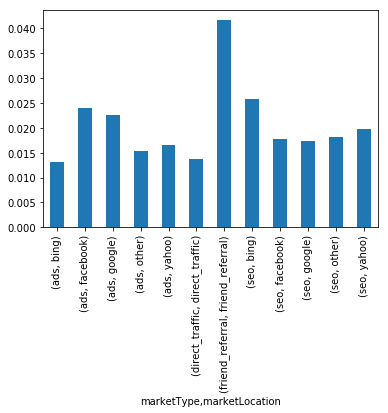

In [144]:
test_results_Sub2_summary = test_results_Sub2.groupby(['marketType','marketLocation']).converted.sum().reset_index()
test_results_Sub2_summary['total'] = test_results_Sub2.groupby(['marketType','marketLocation']).converted.count().tolist()
test_results_Sub2_summary['percent_converted']=np.divide(test_results_Sub2_summary.converted,test_results_Sub2_summary.total)
test_results_Sub2_summary.groupby(['marketType','marketLocation']).percent_converted.sum().plot.bar()
plt.show()

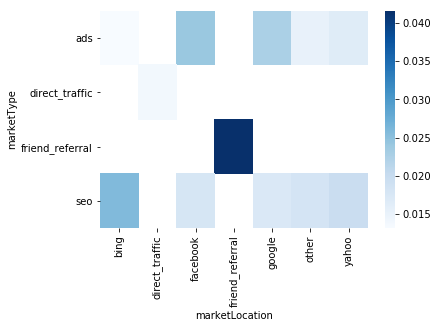

In [157]:
convert_plot = test_results_Sub2_summary.groupby(['marketType','marketLocation']).percent_converted.sum().reset_index().pivot('marketType','marketLocation', "percent_converted")
sns.heatmap(convert_plot,cmap="Blues")
plt.show()

In terms of coversion rate, it looks as if friend referrals has the highest. That's difficult to control from a company though, unless they can modulate the number of referrals a person can send. Outside of that, the highest conversion rates tend to be through Bing SEO work, and Facebook and Google ads. 

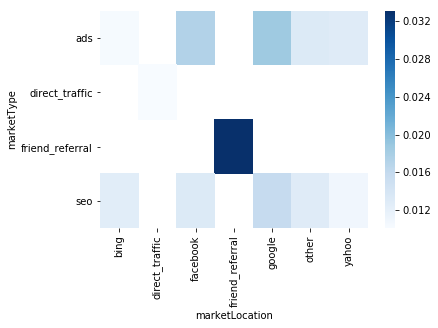

In [169]:
test_results_Sub3 = test_results_Sub.query('test == 1')
test_results_Sub3_summary = test_results_Sub3.groupby(['marketType','marketLocation']).converted.sum().reset_index()
test_results_Sub3_summary['total'] = test_results_Sub3.groupby(['marketType','marketLocation']).converted.count().tolist()
test_results_Sub3_summary['percent_converted']=np.divide(test_results_Sub3_summary.converted,test_results_Sub3_summary.total)
convert_plot2 = test_results_Sub3_summary.groupby(['marketType','marketLocation']).percent_converted.sum().reset_index().pivot('marketType','marketLocation', "percent_converted")
sns.heatmap(convert_plot2,cmap="Blues")
plt.show()

Compared to the test subjectcts, the pattern pretty much holds.

so, where is the best place to focus efforts?

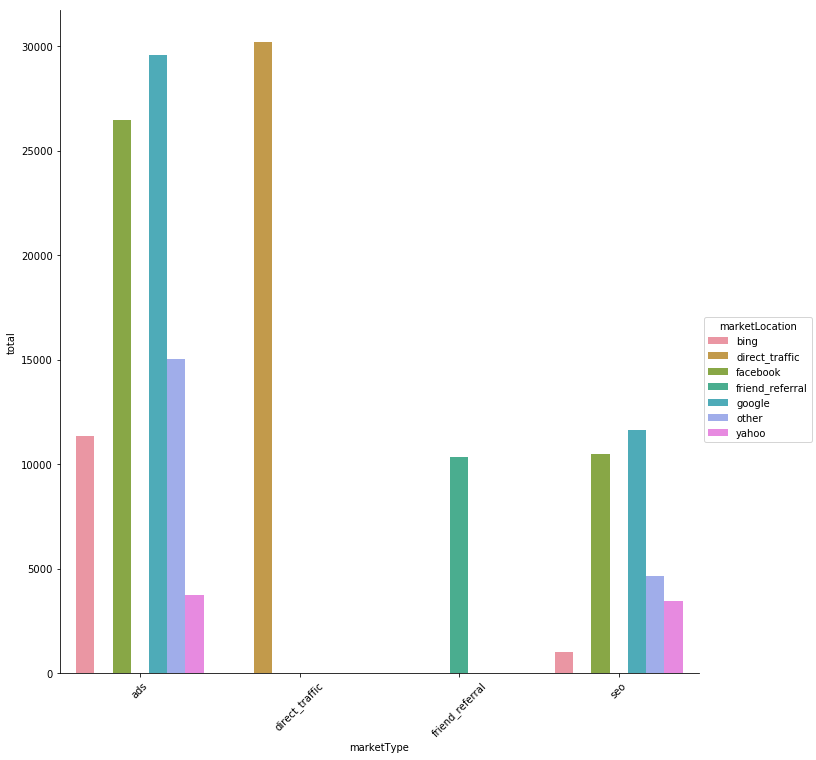

In [168]:
sns.set_palette("husl")
sns.factorplot(x="marketType", y="total", hue="marketLocation",size=10,
                    data=test_results_Sub2_summary.reset_index(),
                    kind="bar")
plt.xticks(rotation=45)

plt.show()

In terms of current volume, this is telling us that Adds get more hits than SEOs, and that Facebook and Google bring in way more visitors than Bing, so maybe that's where the focus should be. There is also a large amount of Direct Traffic, suggesting there's a large user base in place that know the address and type it in directly... but from the information before, it doesn't lead to much conversion.

## Conclusion
These data suggest that the most effective marketing to get people to the site are add campaigns on google and facebook. The only more effective method of generating conversion are friend referrals, but those are likely difficult to control.

In addition to putting money into facebook and google adds, it seems as though raising the price from 39 dollars to 59 dollars, although reducing conversion overall, would generate more in profit. Further, we could have stopped the experiment early (247107 users sooner) and still detected the difference.